In [1]:
import torch
import os
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from model import CGMPredictor
from dataset import CGMDataset, collate_fn

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
test_dataset = CGMDataset(file="./Datasets/Test", max_len=512*4, pred_time=90, augment=False, max_gap=30, min_gap=2)

test_loader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn,
    drop_last=True,
)


Users loaded: 100%|██████████| 193/193 [00:04<00:00, 45.27it/s]


In [3]:


# Assuming you have a model class defined elsewhere
model = CGMPredictor(
    n_embd=8*48,
    n_head=8,
    n_layer=3,
    dropout=0.3,
)
model = torch.compile(model)
model.to(device)
model.eval()

print(model.num_params())

17828401


In [4]:

# Define loss function
criterion = nn.L1Loss()  # Replace with your loss function if different

In [5]:
test_dataset.max_gap = 180
test_dataset.max_len = 512*16
test_dataset.max_range = 1.5
test_dataset.augment = False

In [6]:
iteration = 23000
model_path = f'./Pretrained/model_iter_{iteration}.pth'
model.load_state_dict(torch.load(model_path, map_location=device))


<All keys matched successfully>

In [8]:
from tqdm.auto import tqdm
num_iter = 100

total_loss, total_samples = 0, 0
with torch.no_grad():
    for i in tqdm(range(num_iter)):
        while total_samples < num_iter:
            sample = test_dataset[0]
            cgm = sample['cgm'].to(device).unsqueeze(0)
            basal = sample['basal'].to(device).unsqueeze(0)
            bolus = sample['bolus'].to(device).unsqueeze(0)
            cgm_time = sample['cgm_time'].to(device).unsqueeze(0)
            basal_time = sample['basal_time'].to(device).unsqueeze(0)
            bolus_time = sample['bolus_time'].to(device).unsqueeze(0)
            target_cgm = sample['target_cgm'].to(device)
            target_time = sample['target_time'].to(device)
            pred_time = sample['pred_time'].to(device)
            pred_time = 9

            target_time = target_time[-100:-20].unsqueeze(0)
            target_cgm = target_cgm[-100:-20].unsqueeze(0)
            
        
            if bolus.shape[1] > 0 and basal.shape[1] > 0 and all((cgm_time[0][-499:-1] - cgm_time[0][-500:-2]) < 2):
                output_cgm = model(cgm, basal, bolus, cgm_time, basal_time, bolus_time, target_time, pred_time)
                loss = criterion(model.normalize_cgm(output_cgm), model.normalize_cgm(target_cgm))
                total_loss += loss.item()
                
                total_samples += 1
                break
   

avg_loss = total_loss / total_samples
print(f'Validation MSE Loss: {avg_loss:.4f}')

  0%|          | 0/100 [00:00<?, ?it/s]

Validation MSE Loss: 0.2812


In [8]:
import torch
from tqdm.auto import tqdm
import math

def map_and_round(n, in_min, in_max, out_min, out_max, x):
    # Map n from input to output range
    mapped = (n - in_min) / (in_max - in_min) * (out_max - out_min) + out_min

    # Round to nearest multiple of x
    rounded = round(mapped / x) * x

    # Make sure the result is a multiple of x and within [out_min, out_max]
    # Adjust if out of bounds
    if rounded < out_min:
        # Round up to next valid multiple of x within range
        rounded = ((out_min + x - 1) // x) * x
    elif rounded > out_max:
        # Round down to previous valid multiple of x within range
        rounded = (out_max // x) * x

    return rounded

# --------------------------------------------------------------------------
# configuration
# --------------------------------------------------------------------------
num_iter  = 10_000                       # how many batches to draw
n_repeats = 18                           # your constant
device    = 'cuda'                       # or "cpu"
outfile   = 'eval_results.pt'
# --------------------------------------------------------------------------

model.eval()
data_iter = iter(test_loader)            # build iterator once
samples   = []                           # one entry per *individual sample*

with torch.no_grad(), \
     torch.amp.autocast(device_type='cuda', dtype=torch.bfloat16):

    for i in tqdm(range(num_iter)):
        try:
            batch = next(data_iter)
            if batch['bolus'].shape[1] == 0 and batch['basal'].shape[1] == 0:
                print("shape error")
                raise ValueError()
        except StopIteration:            # went through the loader -> restart
            data_iter = iter(test_loader)
            batch = next(data_iter)

        test_dataset.max_len = map_and_round(i, 0, num_iter, 512*4, 512*16, 256)
        # ------------ move to device --------------------------------------
        cgm         = batch['cgm'       ].to(device)   # [B, …]
        basal       = batch['basal'     ].to(device)   # ragged length!
        bolus       = batch['bolus'     ].to(device)
        cgm_time    = batch['cgm_time'  ].to(device)
        basal_time  = batch['basal_time'].to(device)
        bolus_time  = batch['bolus_time'].to(device)
        target_cgm  = batch['target_cgm'].to(device)
        target_time = batch['target_time'].to(device)  # [B, N]

        # ------------ build pred_time / repeated target_time --------------
        B, N = target_time.shape
        target_time_rep = target_time.repeat(1, n_repeats)          # [B,N*n]
        target_cgm_rep = target_cgm.repeat(1, n_repeats)          # [B,N*n]
        pred_row = torch.arange(1, n_repeats + 1,
                                device=target_time.device)\
                   .repeat_interleave(N)                            # [N*n]
        pred_time = pred_row.unsqueeze(0).repeat(B, 1)              # [B,N*n]

        # ------------ forward ---------------------------------------------
        output_cgm = model(cgm, basal, bolus,
                           cgm_time, basal_time, bolus_time,
                           target_time_rep, pred_time)

        # ------------ split batch into individual “sample” dicts ----------
        for i in range(B):
            samples.append(dict(
                # inputs
                cgm         = cgm        [i].cpu(),
                basal       = basal      [i].cpu(),
                bolus       = bolus      [i].cpu(),
                cgm_time    = cgm_time   [i].cpu(),
                basal_time  = basal_time [i].cpu(),
                bolus_time  = bolus_time [i].cpu(),
                target_time = target_time_rep[i].cpu(),
                pred_time   = pred_time  [i].cpu(),
                # targets & outputs
                target_cgm  = target_cgm_rep [i].cpu(),
                output_cgm  = output_cgm     [i].cpu()
            ))
            
test_dataset.max_len = 512*16
# --------------------------------------------------------------------------
# save – a single list with len == num_iter * batch_size
# --------------------------------------------------------------------------
torch.save(samples, outfile)
print(f"Saved {len(samples)} samples to {outfile}")

  0%|          | 0/10000 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Saved 10000 samples to eval_results.pt


In [ ]:
import torch
from pathlib import Path

# ----------------------------------------------------------------------
# adjust these two lines if necessary
# ----------------------------------------------------------------------
ckpt_file = Path('eval_results.pt')          # <- your file
# ----------------------------------------------------------------------

assert ckpt_file.is_file(), f'{ckpt_file} not found'
samples = torch.load(ckpt_file, map_location='cpu')
print(f'\nLoaded {ckpt_file}.')

# ----------------------------------------------------------------------
# helper that formats a tensor nicely (and never crashes)
# ----------------------------------------------------------------------
def tensor_info(t: torch.Tensor, width=20) -> str:
    shape_str = str(tuple(t.shape)).ljust(width)
    dtype_str = str(t.dtype).ljust(9)
    return f'shape={shape_str} dtype={dtype_str}'

# ----------------------------------------------------------------------
# CASE 1 – the checkpoint is a single dict with big tensors
# ----------------------------------------------------------------------
if isinstance(samples, dict):
    print('\nFile type: dict')
    for k, v in samples.items():
        if torch.is_tensor(v):
            print(f'  {k:<12}{tensor_info(v)}')
        else:
            print(f'  {k:<12}{v}')

# ----------------------------------------------------------------------
# CASE 2 – the checkpoint is a list of per-sample dicts (ragged)
# ----------------------------------------------------------------------
elif isinstance(samples, list) and all(isinstance(s, dict) for s in samples):
    print(f'\nFile type: list  (len = {len(samples)})')
    first = samples[0]
    print('First entry:')
    for k, v in first.items():
        if torch.is_tensor(v):
            print(f'  {k:<12}{tensor_info(v)}')
        else:
            print(f'  {k:<12}{v}')

    # Optional statistics over the whole list
    seq_keys = ['basal', 'bolus']
    for key in seq_keys:
        if key in first and torch.is_tensor(first[key]):
            lengths = [s[key].shape[-1] for s in samples]
            print(f'\n{key.capitalize()} length : '
                  f'min = {min(lengths)}  max = {max(lengths)}  '
                  f'avg = {sum(lengths)/len(lengths):.1f}')

# ----------------------------------------------------------------------
# Anything else is unexpected
# ----------------------------------------------------------------------
else:
    raise TypeError(f'Unexpected checkpoint structure: {type(samples)}')


In [ ]:
import matplotlib.pyplot as plt

def loss_valid_mask(cgm_time, target_time, output_cgm, target_cgm, max_gap=999999, gap_range=999999):
    dif = torch.cat([torch.tensor([0]).to(device), cgm_time[1:] - cgm_time[:-1]])

    cgm_index = (cgm_time.unsqueeze(1) < target_time.unsqueeze(0)).long().cumsum(0).argmax(0) - 1
    cgm_index = cgm_index.clamp(min=-1) # the largest cgm_time that is still smaller than each target_time
    
    indices = torch.arange(len(cgm_time)).to(device)

    valid_indices = (cgm_index.unsqueeze(1) >= indices.unsqueeze(0)) & (cgm_index.unsqueeze(1) <= indices.unsqueeze(0)+gap_range)
    mask = (dif.unsqueeze(0) < max_gap).repeat(valid_indices.shape[0], 1) | ~valid_indices
    mask = torch.all(mask, dim=1)
    return mask

def plot_loss(name, bin_size=256):

    rows = 3
    cols = 6
    fig, axes = plt.subplots(rows, cols, figsize=(30, 15))
    axes = axes.flatten()
    max_gap = 2
    gap_range = 12*24*3

    for idx, pred_time in enumerate(tqdm(range(1, 19))):
        total_loss, total_samples = torch.zeros(512*16).to(device), torch.zeros(512*16).to(device)
    
        # Inner loop for num_iter with tqdm for progress
        for s in tqdm(samples, leave=False, desc='samples'):
            cgm_time = s['cgm_time'].to(device)
            target_time = s['target_time'][pred_time == s['pred_time']][:-18].to(device)
            output_cgm = s['output_cgm'][pred_time == s['pred_time']][:-18].to(device)
            target_cgm = s['target_cgm'][pred_time == s['pred_time']][:-18].to(device)

            mask = loss_valid_mask(cgm_time, target_time, output_cgm, target_cgm, max_gap, gap_range)

            tokens_in_window = torch.sum(cgm_time.unsqueeze(1) <= (target_time - pred_time).unsqueeze(0), dim=0)
            tokens_in_window = torch.clamp(tokens_in_window, max=len(total_loss)-1).long()
            
            error = output_cgm - target_cgm
            if name == 'MAE':
                error = torch.abs(error)
            elif name == 'RMSE':
                error = error**2

            total_loss = total_loss.index_add(0, tokens_in_window[mask], error[mask])
            total_samples = total_samples.index_add(0, tokens_in_window[mask], torch.ones_like(tokens_in_window[mask]).float())
 
             
        total_loss = (total_loss[:-18] / total_samples[:-18]).to('cpu')
        if name == 'RMSE':
            total_loss = total_loss**0.5
            
        binned_loss = []
        binned_indices = []
        
        for i in range(0, len(total_loss), bin_size):
            current_bin = total_loss[i:i + bin_size]
            binned_loss.append(torch.mean(current_bin).item())
            binned_indices.append(i)
        
        # Plot the binned results
        ax = axes[idx]  # Select the appropriate subplot
        ax.plot(binned_indices, binned_loss)
        ax.set_title(f'pred_time={pred_time * 5} min')
        ax.set_xlabel('Token Index')
        ax.set_ylabel(f'{name}')
        ax.grid(True)
        
    # Adjust layout for better appearance
    plt.tight_layout()
    plt.savefig(f"./Plots/{name}_{bin_size}.png", dpi=300)
    plt.show()

  0%|          | 0/18 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

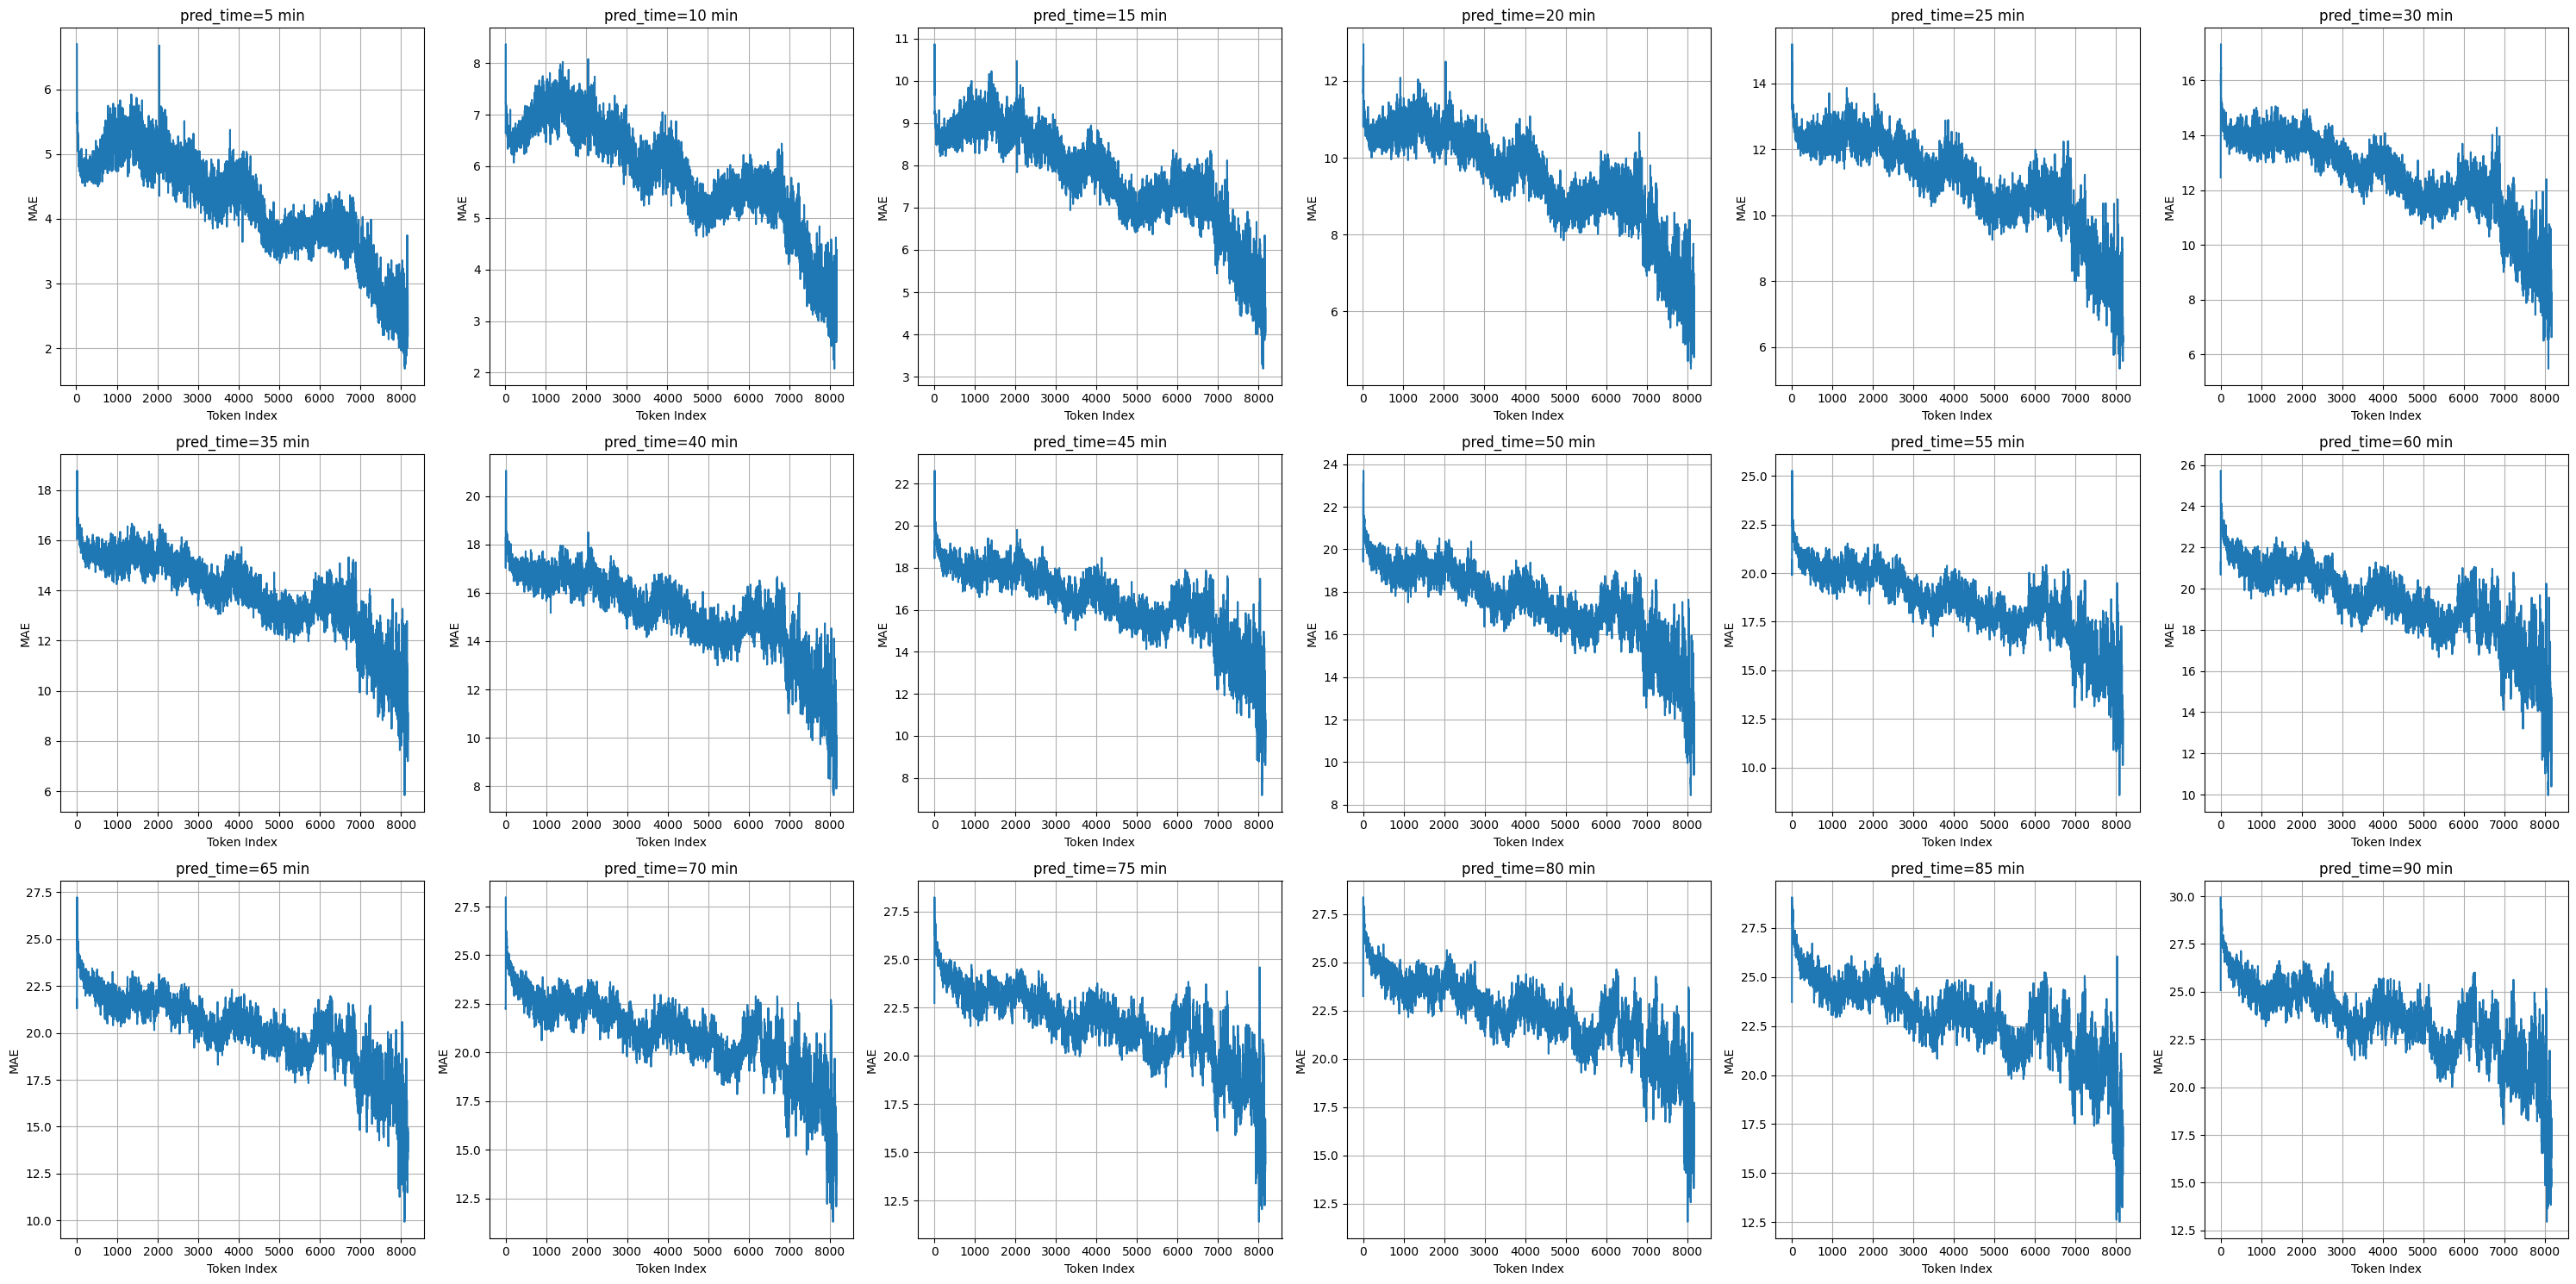

In [35]:
plot_loss('MAE', 1)

  0%|          | 0/18 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

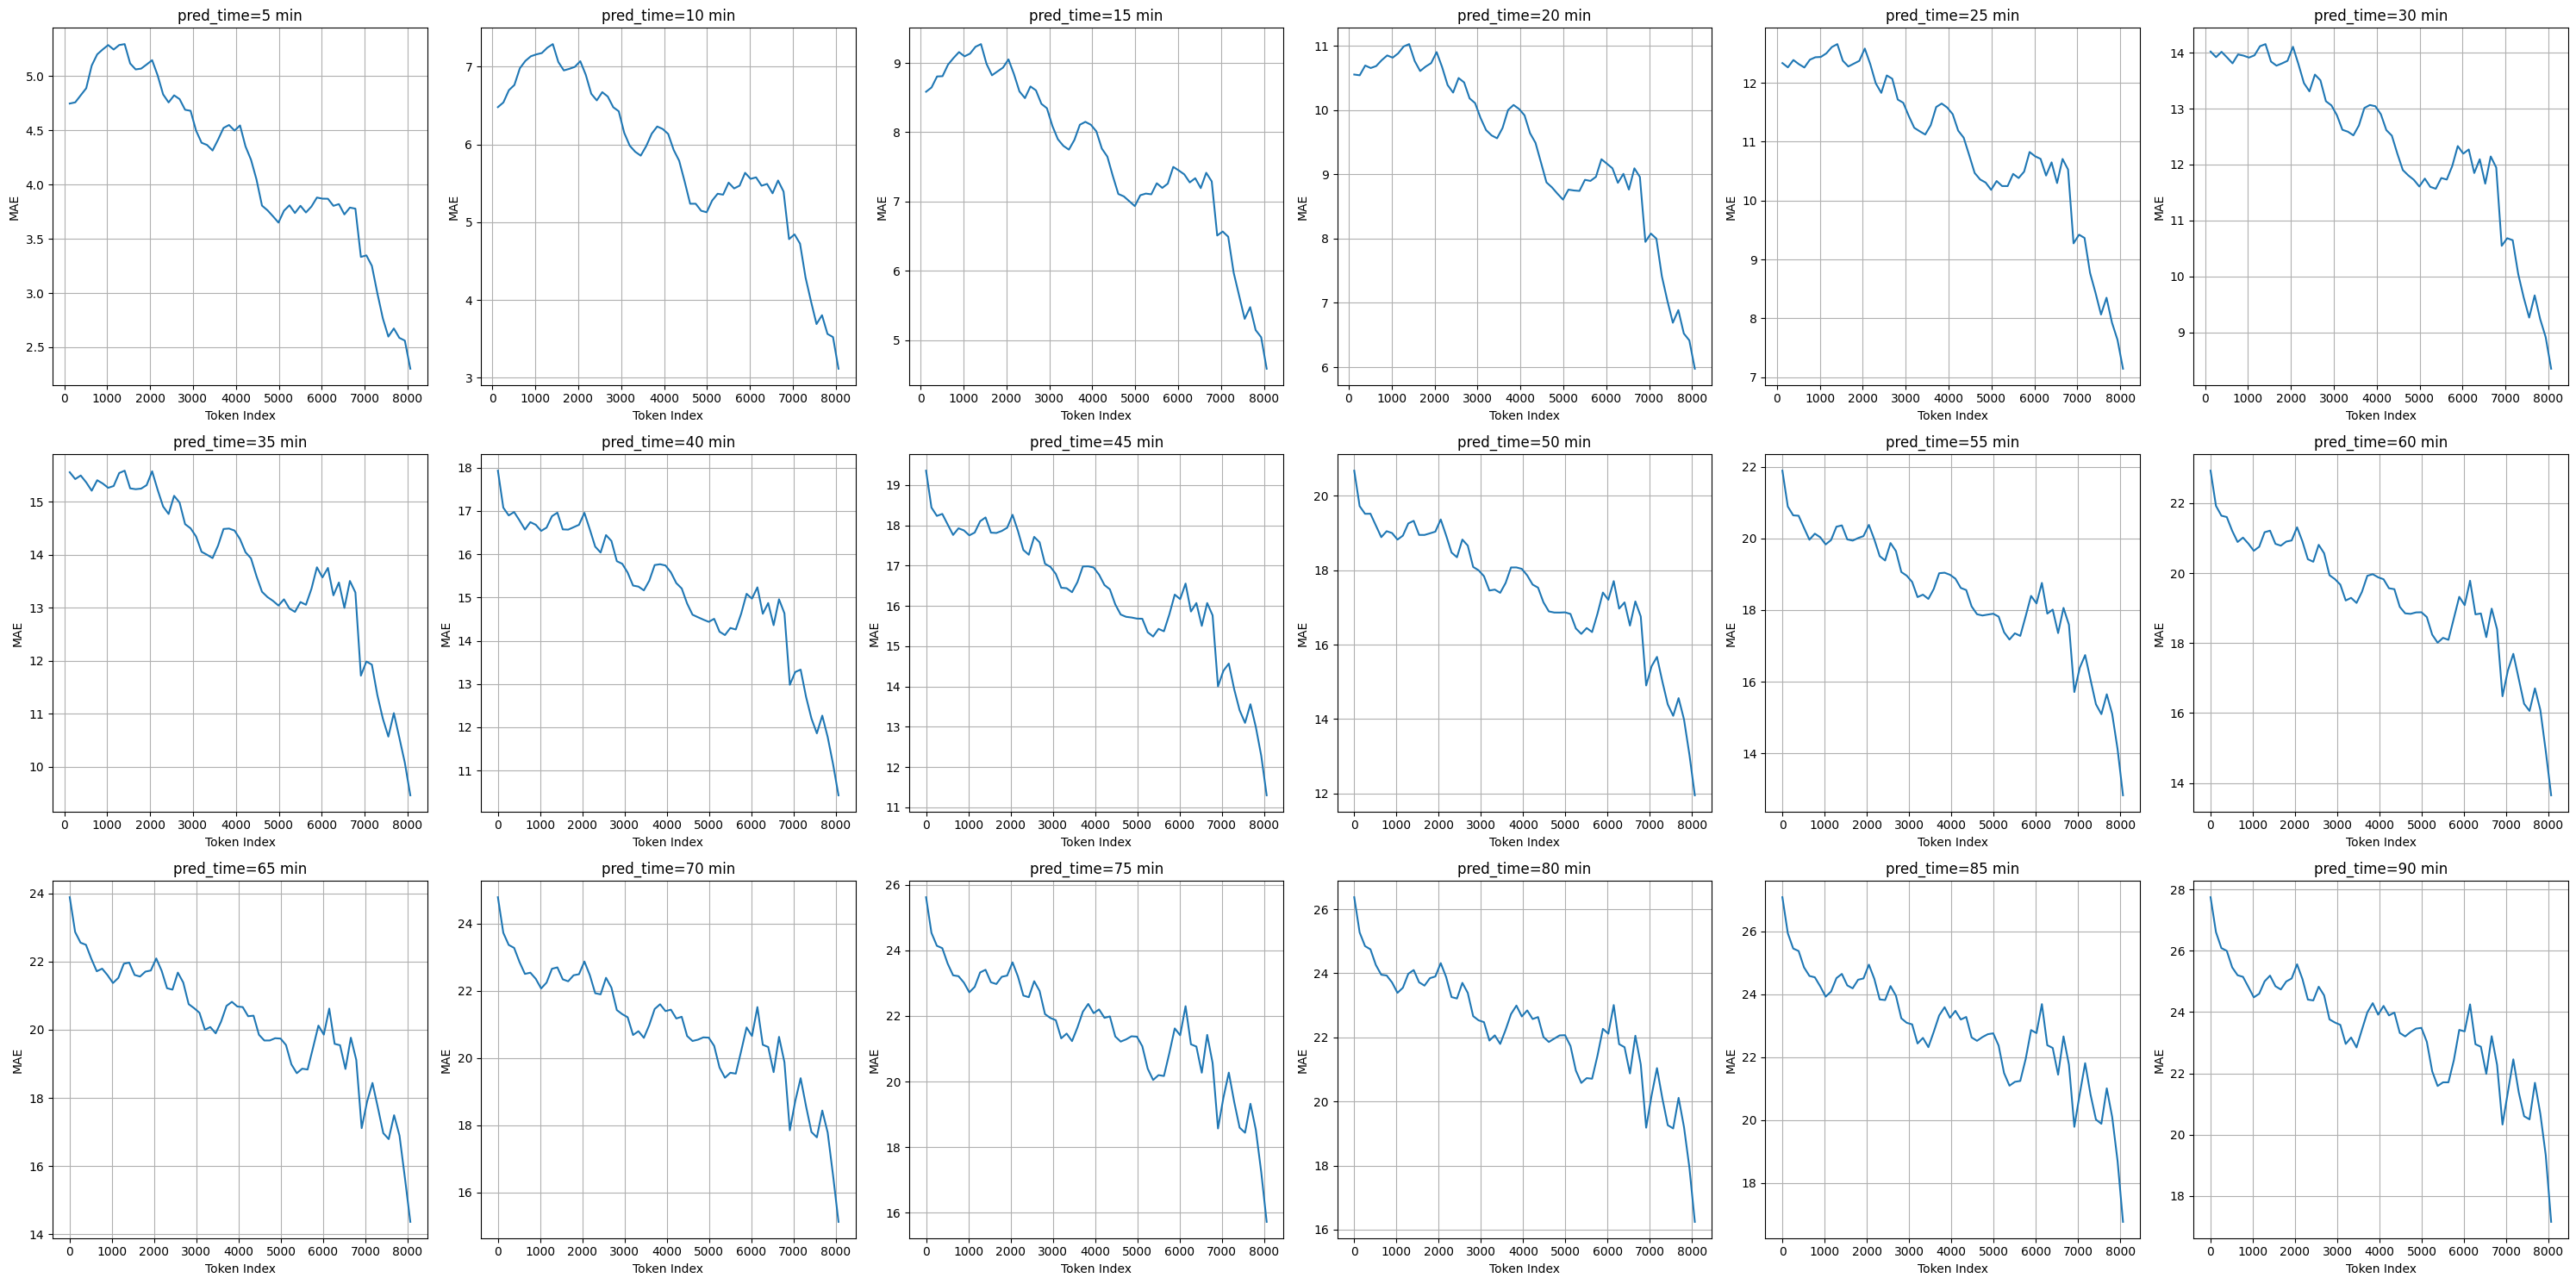

In [36]:
plot_loss('MAE', 128)

  0%|          | 0/18 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

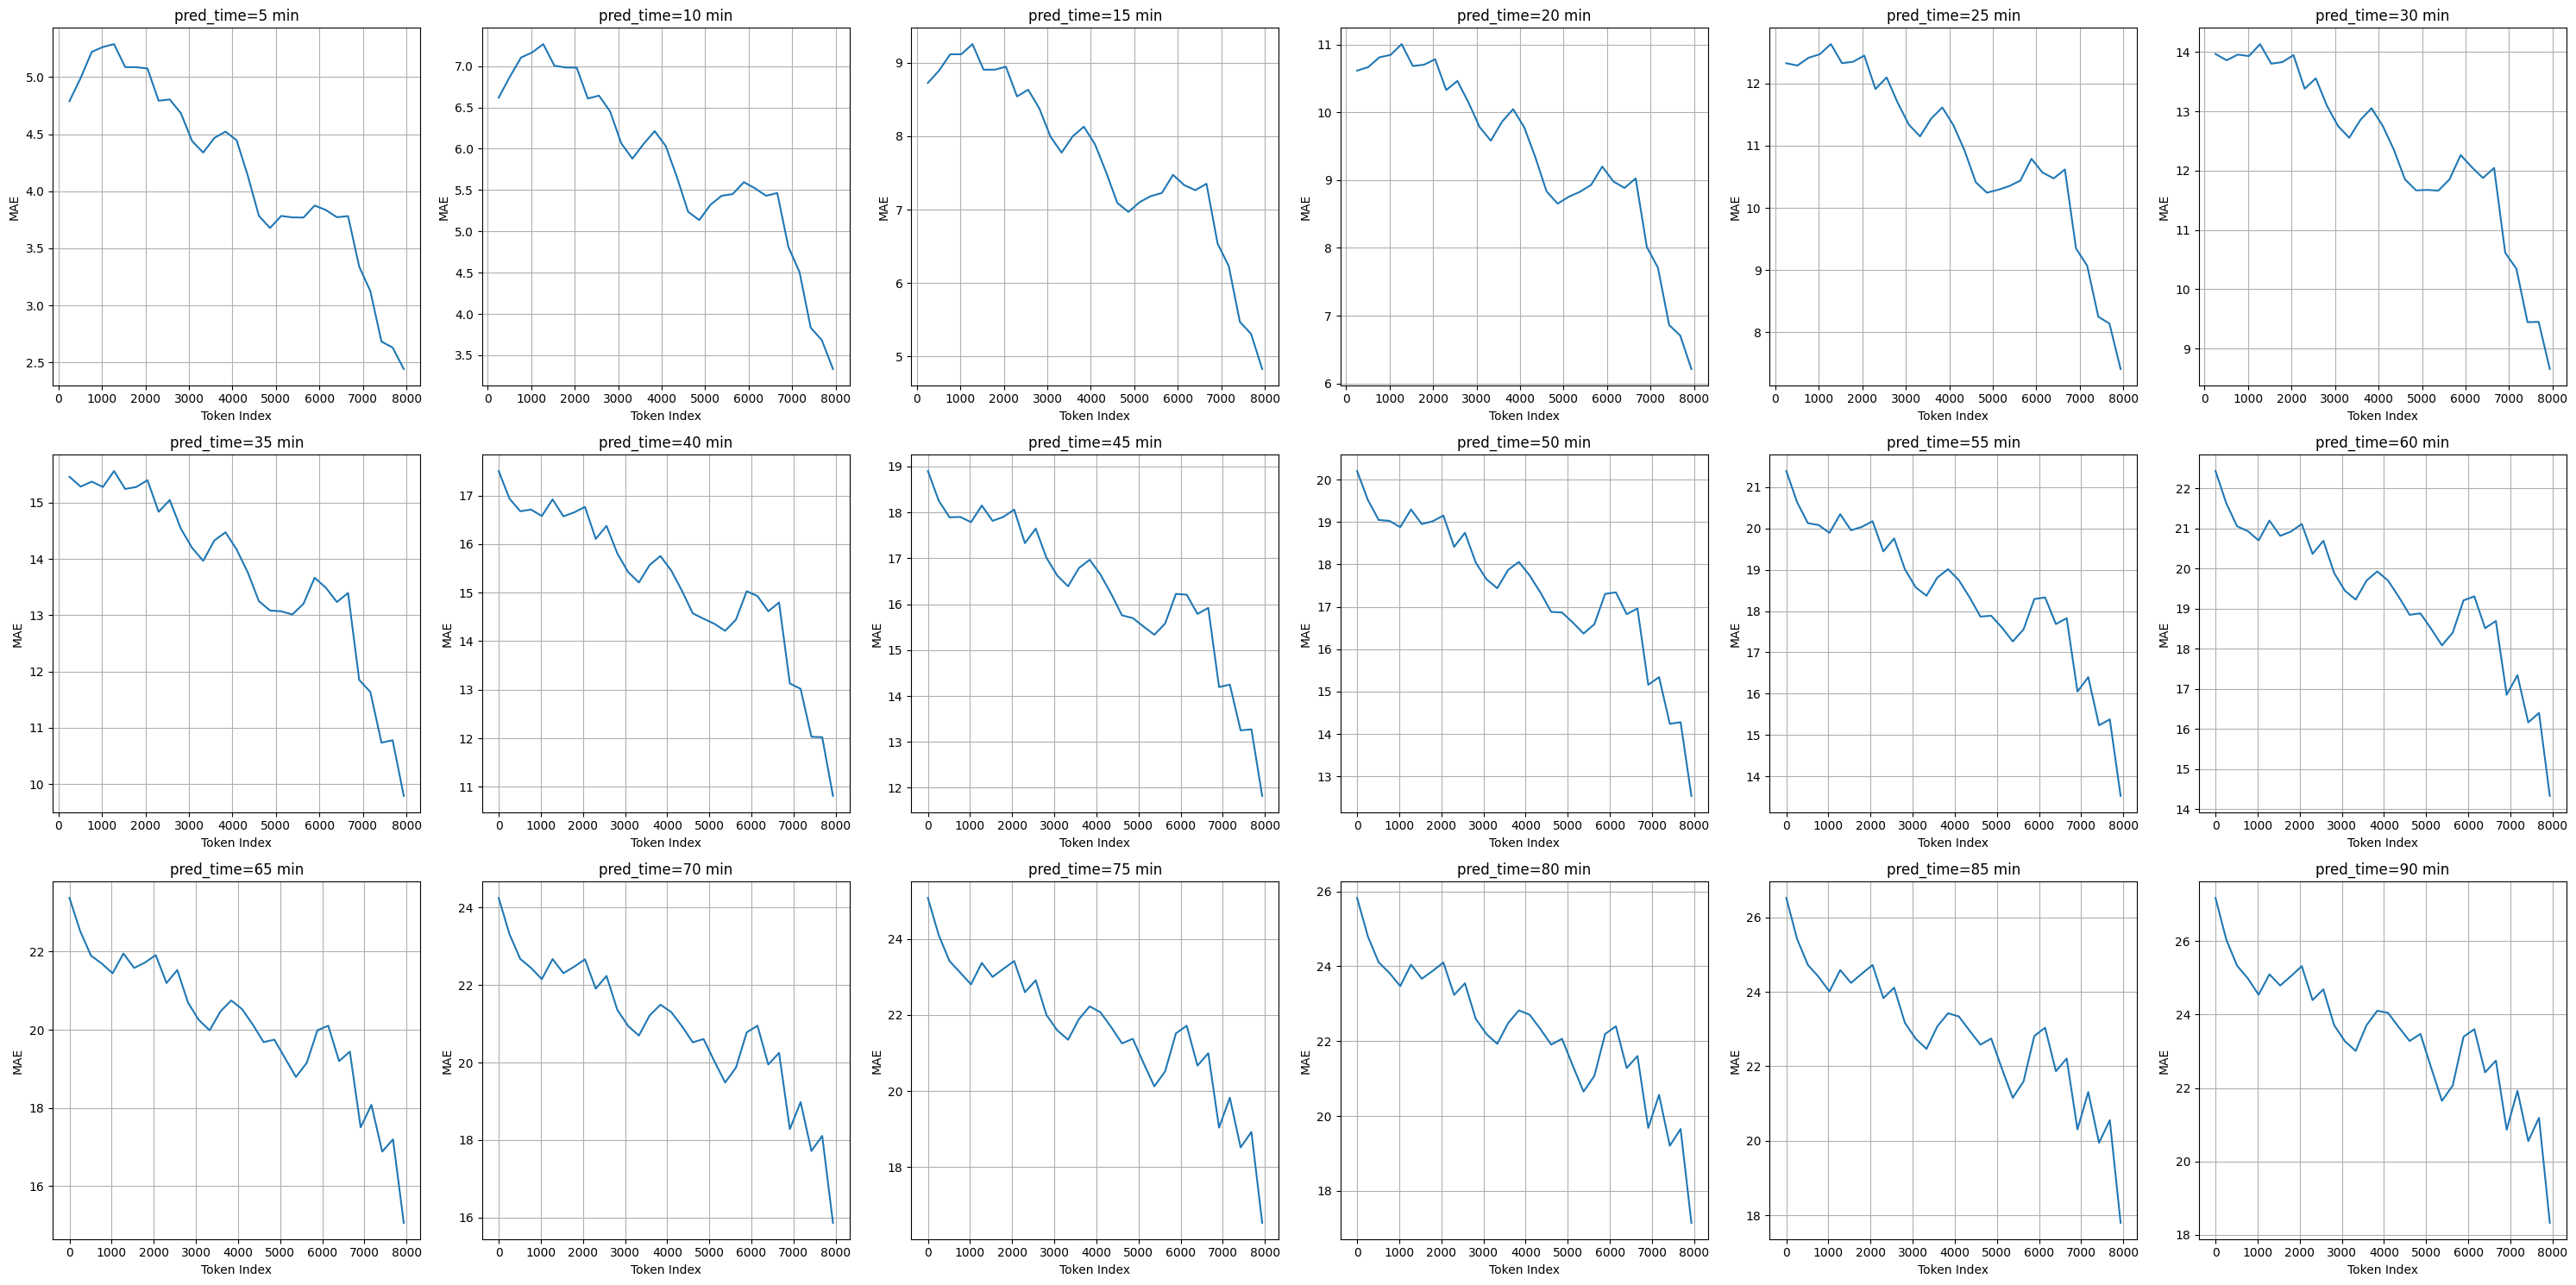

In [37]:
plot_loss('MAE', 256)

  0%|          | 0/18 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

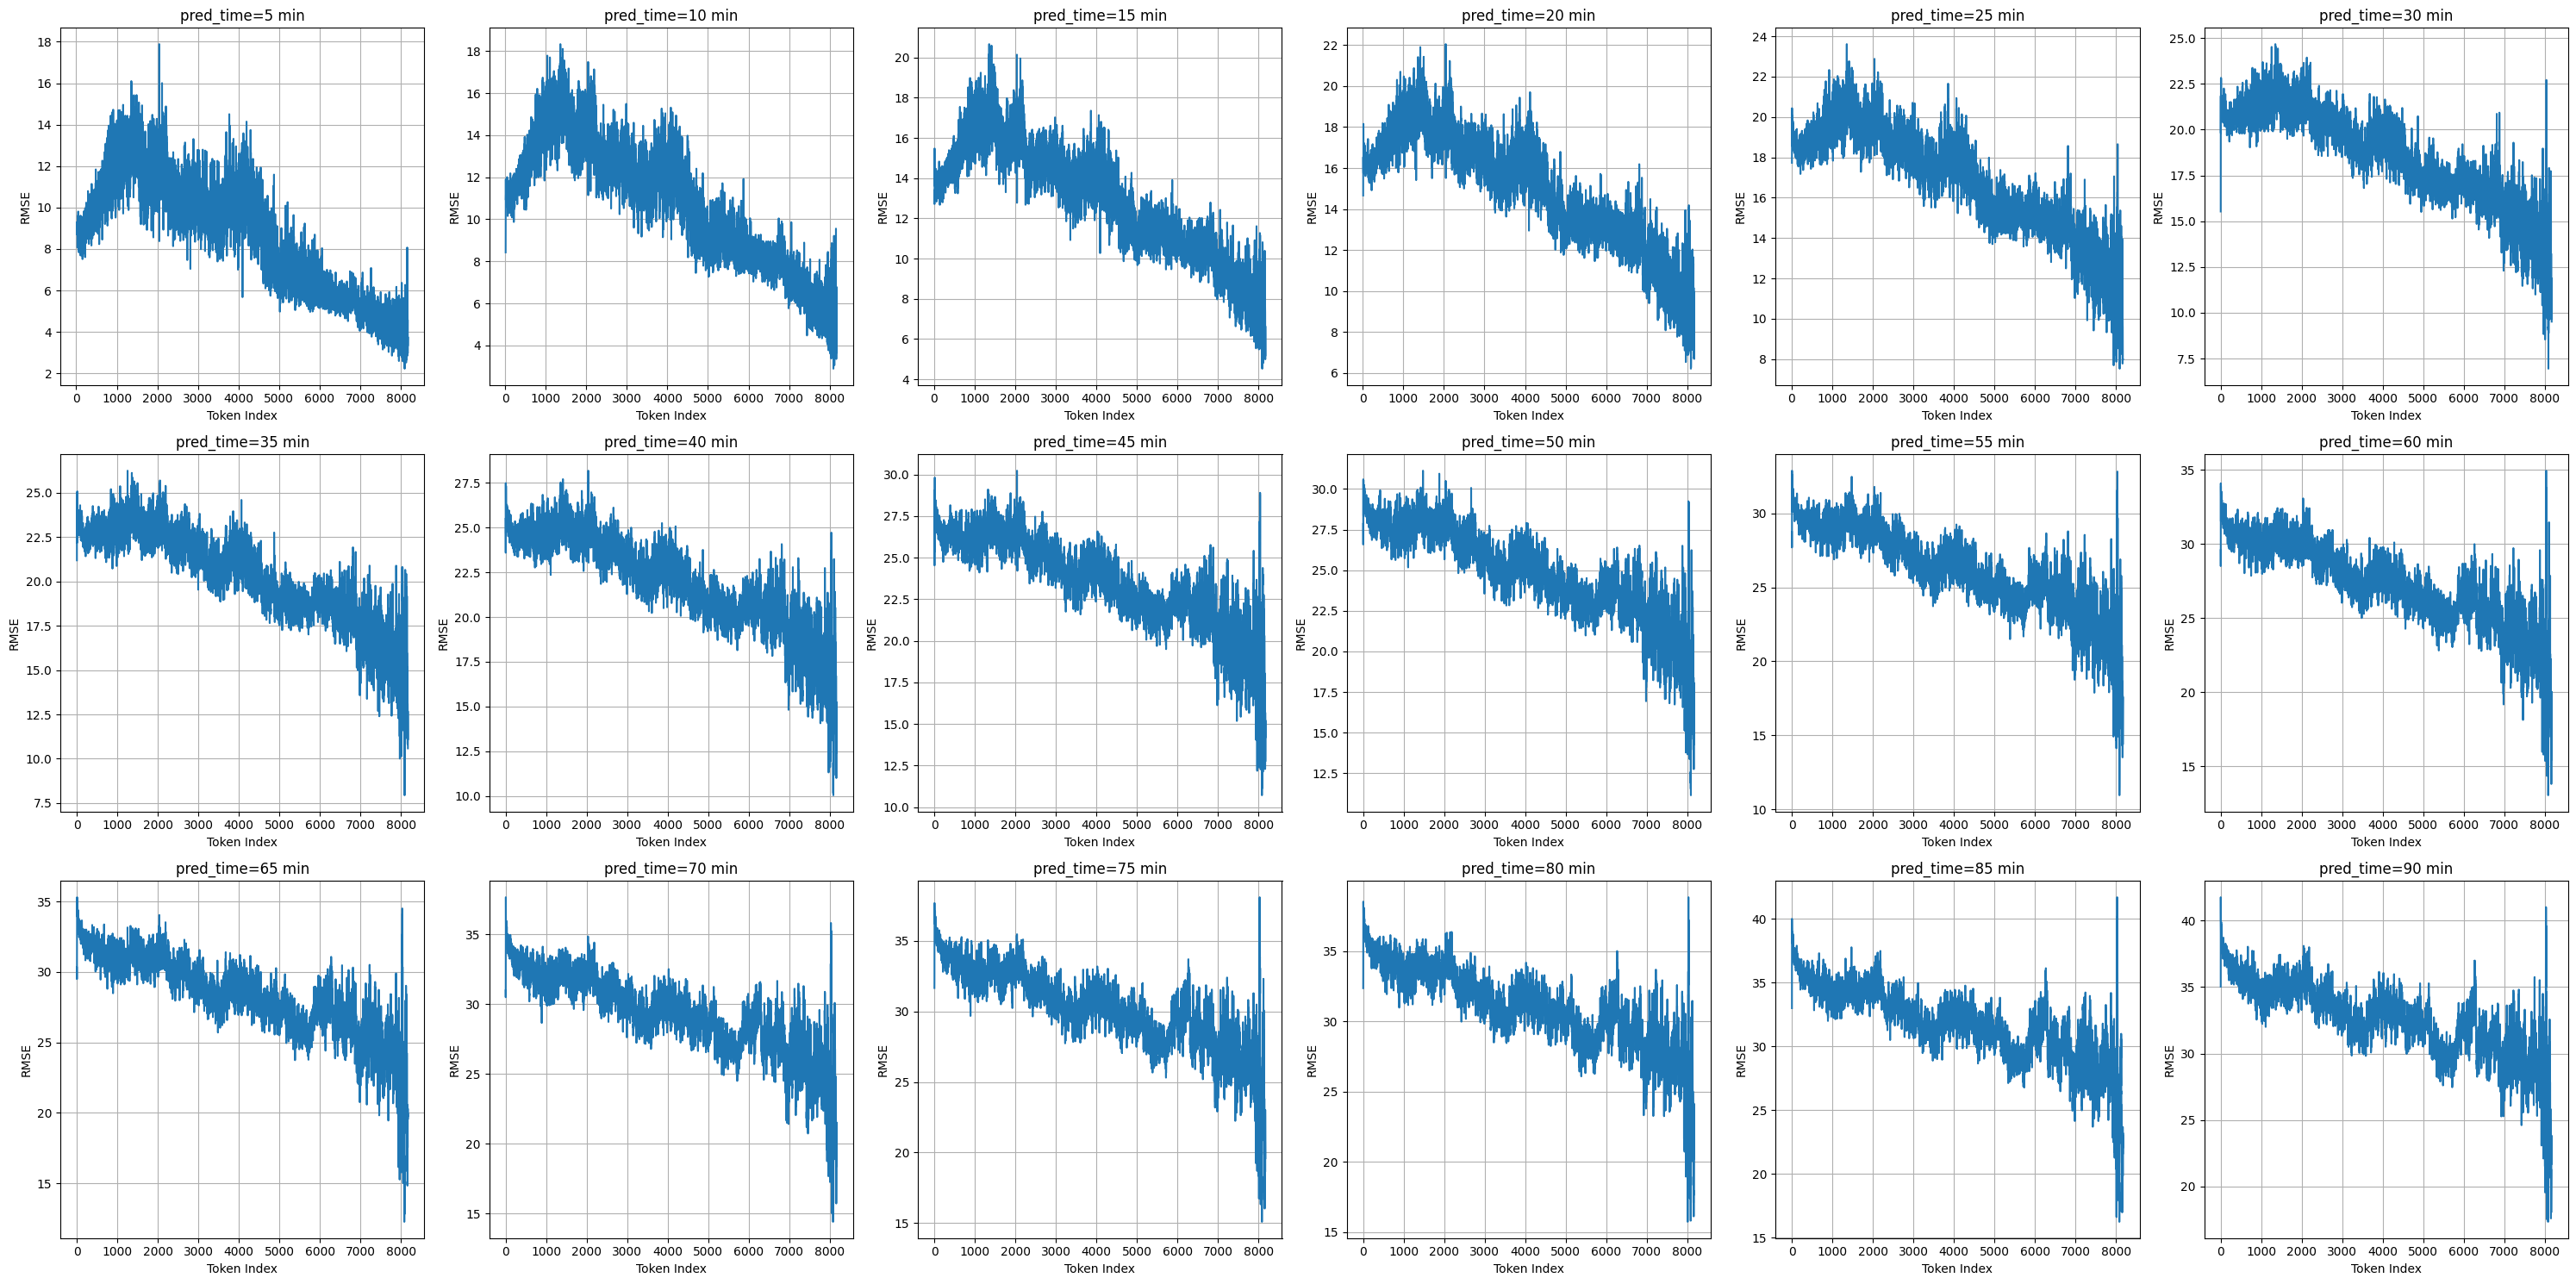

In [38]:
plot_loss('RMSE', 1)

  0%|          | 0/18 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

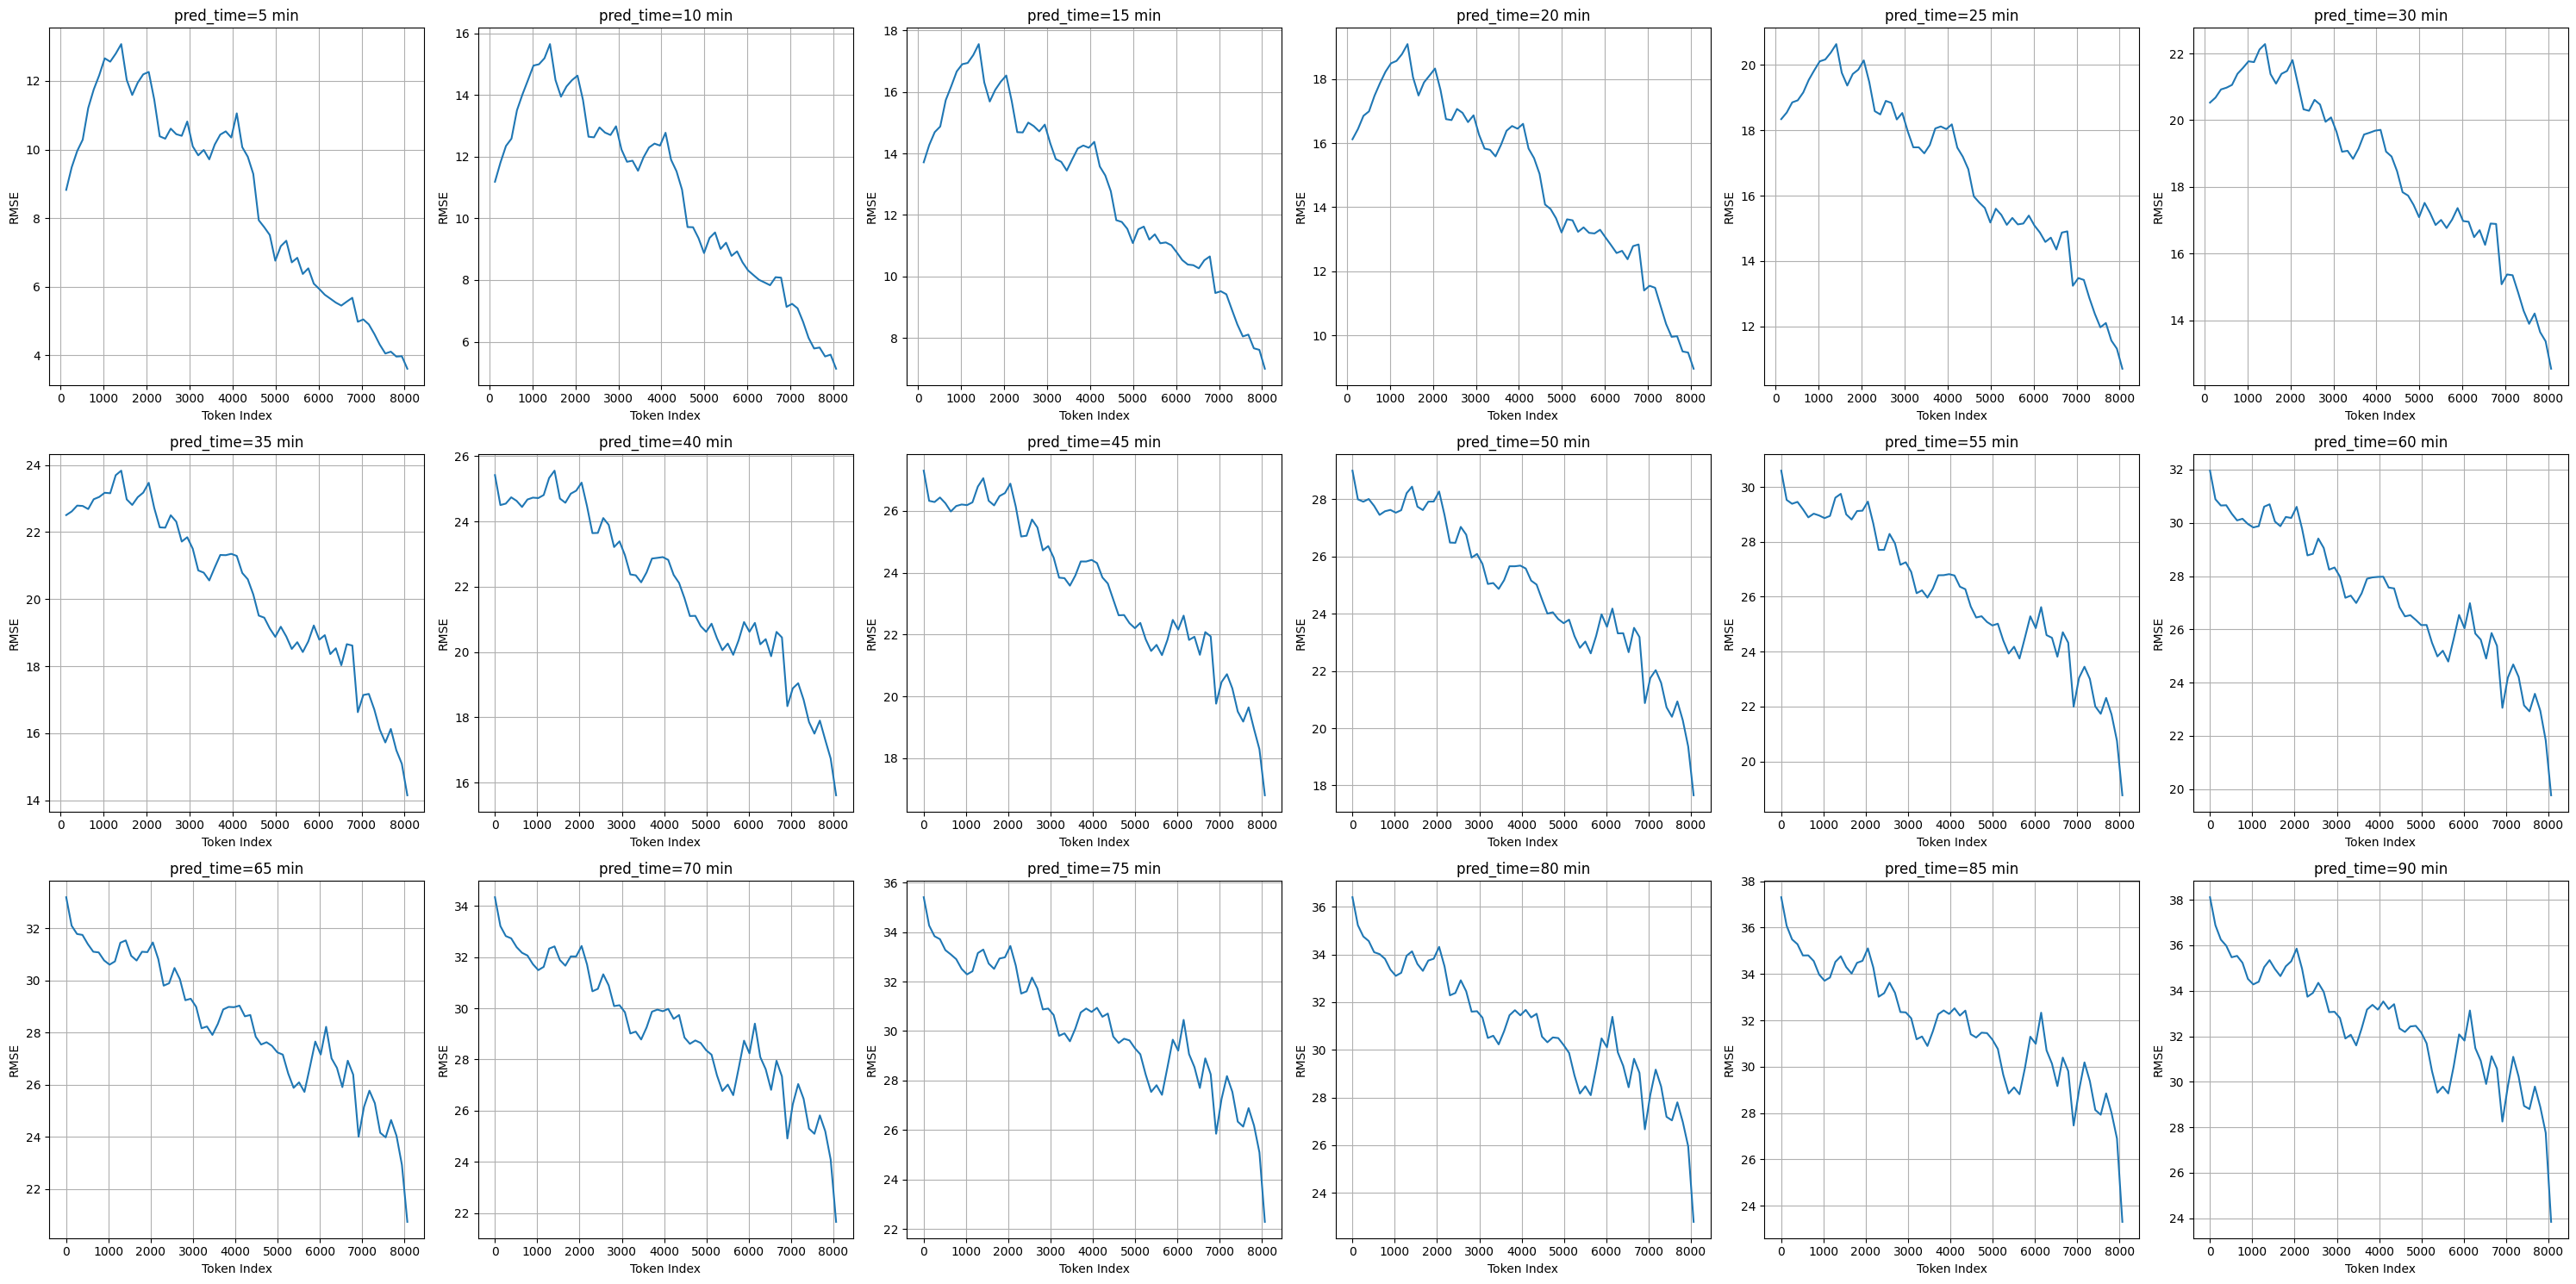

In [39]:
plot_loss('RMSE', 128)

  0%|          | 0/18 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

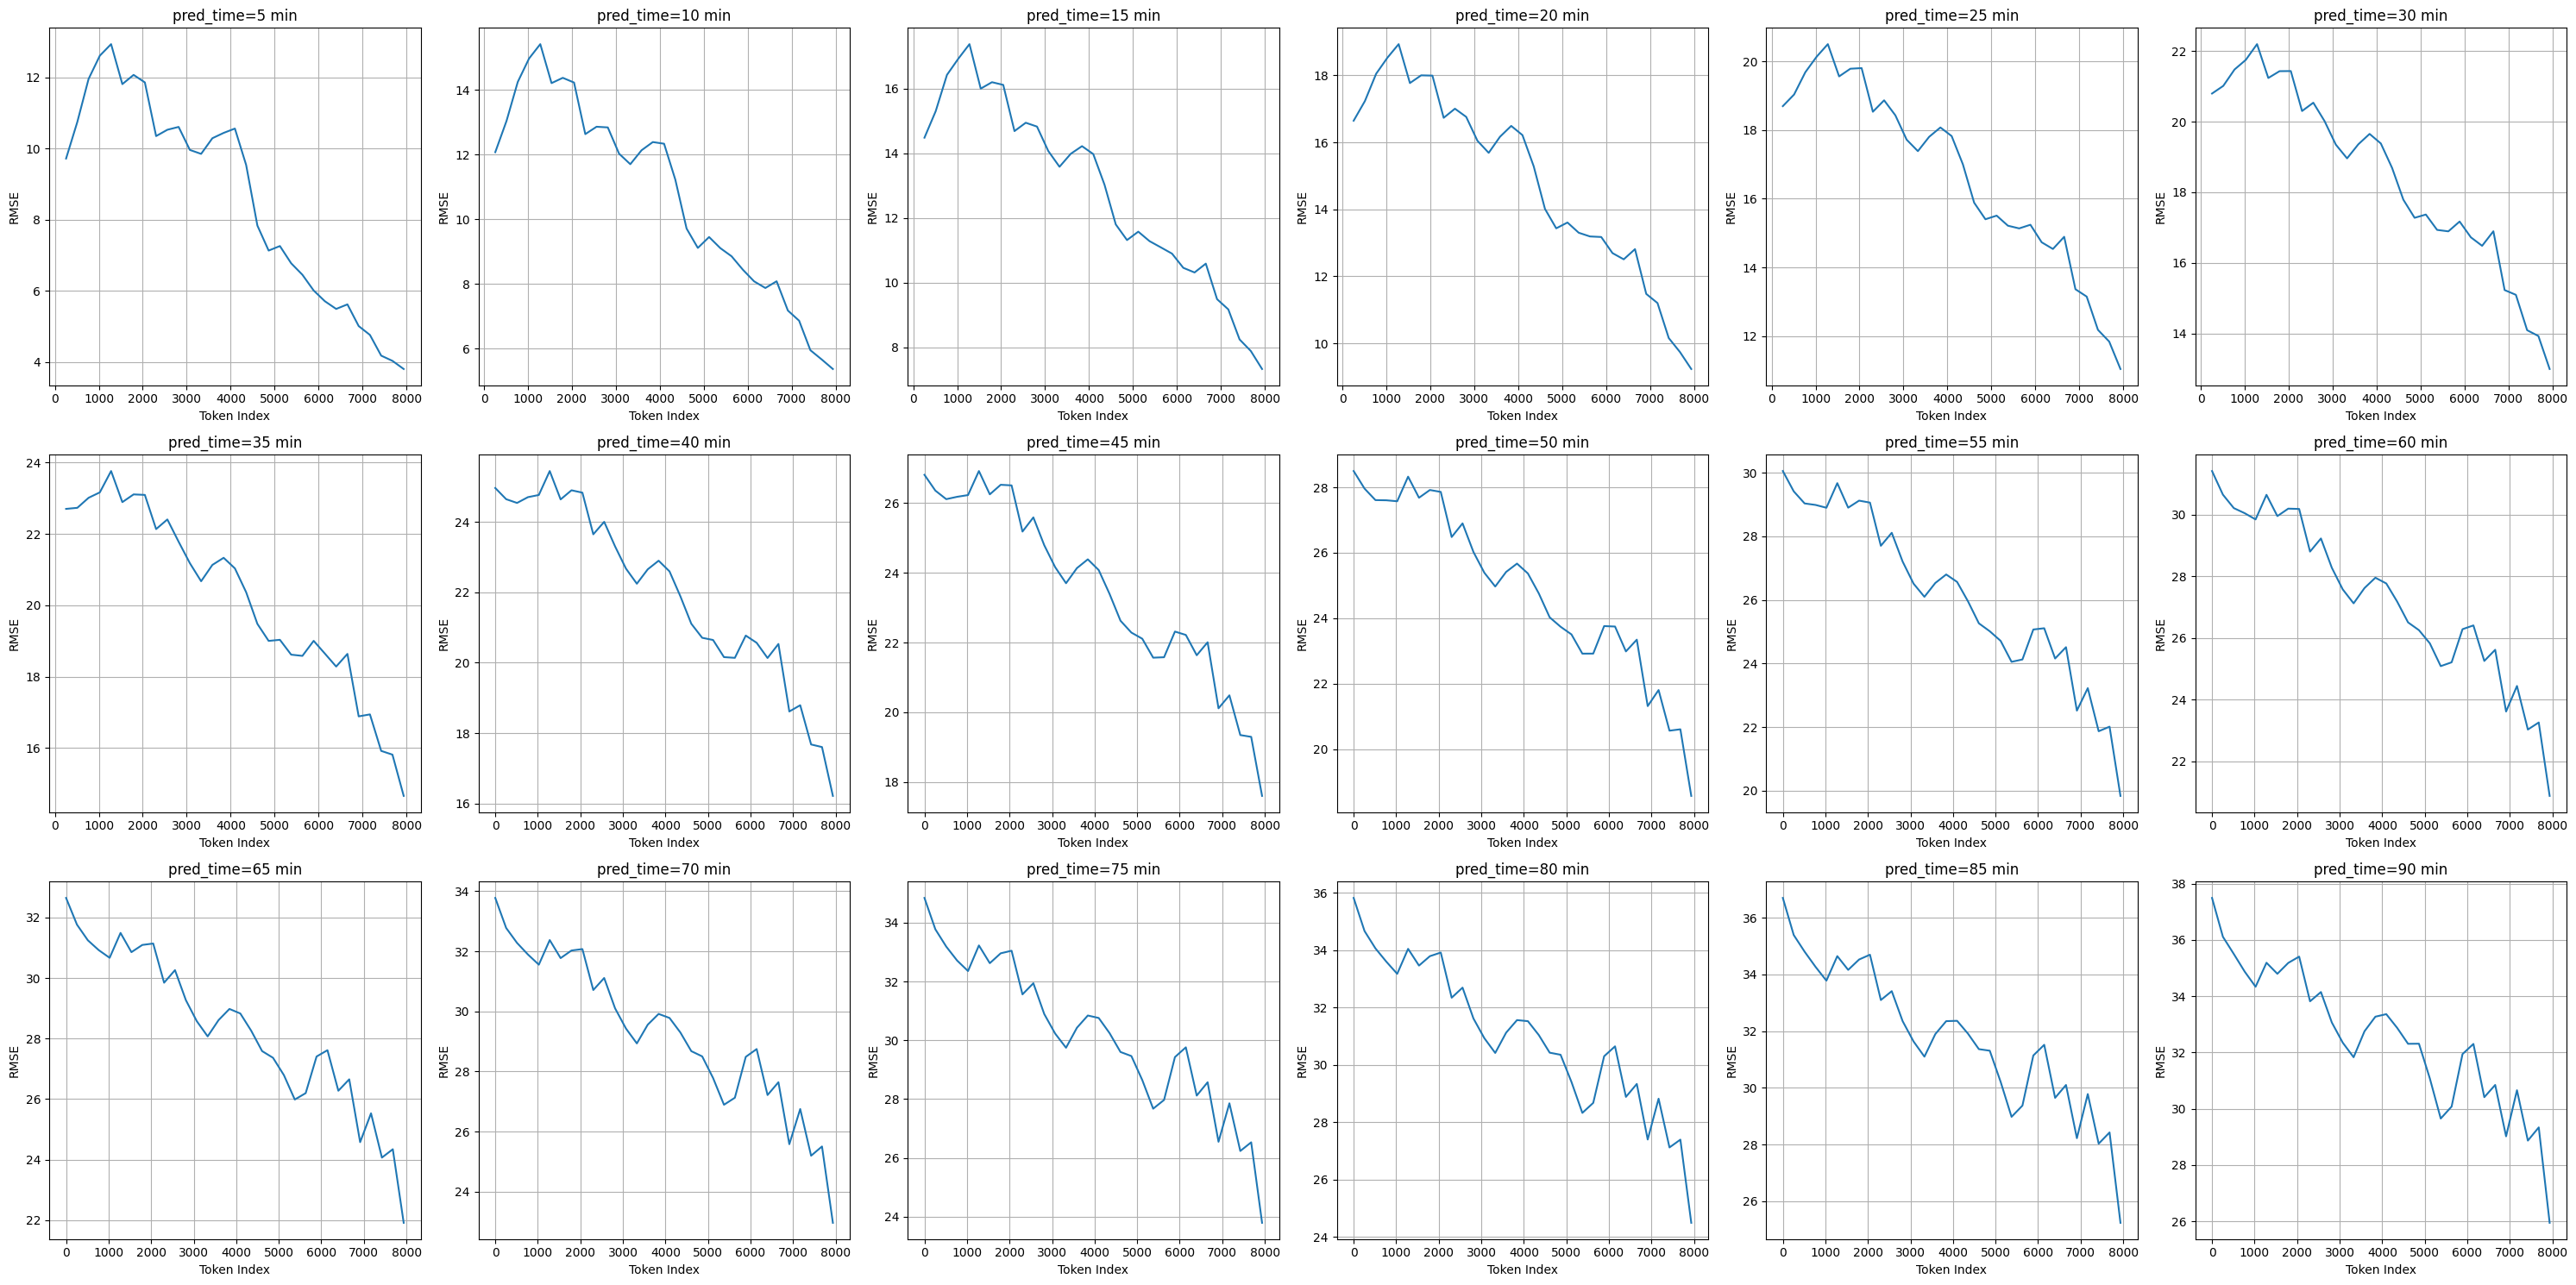

In [40]:
plot_loss('RMSE', 256)

In [133]:
def plot_pred_time(name, bin_size):
    
    max_gap = 2
    gap_range = 12*24*3

    total_loss = torch.zeros(18).to(device)
    total_samples = torch.zeros(18).to(device)
    
        
    for s in tqdm(samples, leave=False, desc='samples'):
        cgm_time = s['cgm_time'].to(device)
        target_mask = ((s['target_time'] > 512*16-bin_size-18) & (s['target_time'] < 512*16-18)).to(device)
        target_time = s['target_time'].to(device)[target_mask]
        output_cgm = s['output_cgm'].to(device)[target_mask]
        target_cgm = s['target_cgm'].to(device)[target_mask]
        pred_time = s['pred_time'].to(device)[target_mask]

            
        mask = loss_valid_mask(cgm_time, target_time, output_cgm, target_cgm, max_gap, gap_range)
        
        if target_time.shape[0] == 0 or mask.sum() == 0:
            continue

        error = output_cgm - target_cgm
        if name == 'MAE':
            error = torch.abs(error)
        elif name == 'RMSE':
            error = error**2
            
        for i in range(1, 19):
            
            m = mask & (pred_time==i)
            
            total_loss[i-1] += error[m].sum()
            total_samples[i-1] += m.sum()

    total_loss = (total_loss / total_samples).to('cpu')
    if name == 'RMSE':
        total_loss = total_loss**0.5
    pred_times = (1 + torch.arange(18)) * 5
    
    plt.figure(figsize=(10, 6))
    plt.plot(pred_times, total_loss, marker='o')
    plt.title(f'{name} vs Prediction Time')
    plt.xlabel('Prediction Time (minutes)')
    plt.ylabel(f'{name}')
    plt.grid(True) 
    plt.legend()
    plt.tight_layout()
    
    plt.savefig(f"./Plots/{name}_single_plot.png", dpi=300)
    plt.show()

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_12910/1381140851.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


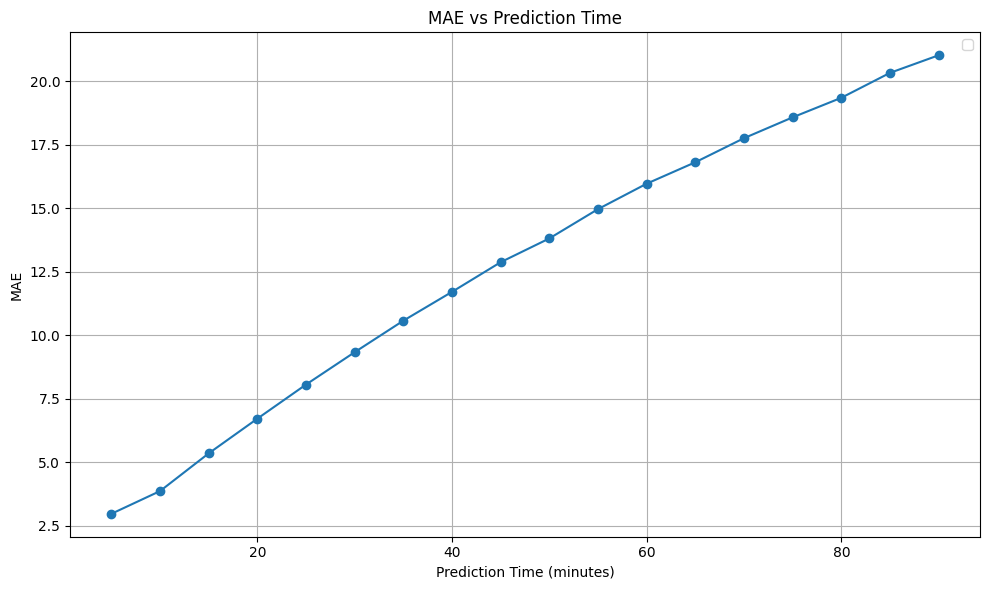

In [134]:
plot_pred_time("MAE", 256)

samples:   0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_12910/1381140851.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


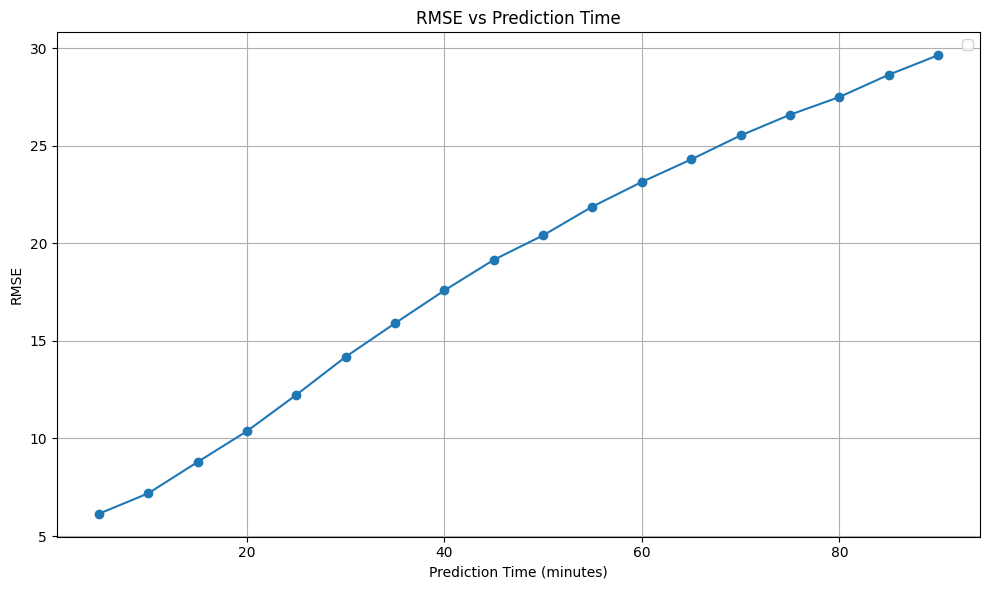

In [135]:
plot_pred_time("RMSE", 256)